# Лабораторная работа №3. Математическое прогнозирование


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import shapiro, pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import f
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product

Данные: https://www.kaggle.com/datasets/somyaagarwal69/gold-forecasting

Признаки:
- Gold_Price - цена на золото (целевая переменная)
- Crude_Oil - цена на нефть
- Interest_Rate - процентная ставка
- USD_INR - обменный курс доллара к рупии
- Sensex - индекс высоколиквидных акций
- CPI - индекс потребительских цен
- USD_Index - индекс доллара США

In [34]:
data = pd.read_csv('./GoldUP.csv')

In [35]:
data

,Date,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
0,01-10-2000,4538,1455.51,8.00,46.318297,3711.02,37.23,116.65
1,01-11-2000,4483,1512.47,8.00,46.783613,3997.99,37.31,115.24
2,01-12-2000,4541,1178.11,8.00,46.745856,3972.12,36.98,109.56
3,01-01-2001,4466,1208.18,8.00,46.536033,4326.72,36.90,110.52
4,01-02-2001,4370,1267.18,7.50,46.514595,4247.04,36.73,112.01
...,...,...,...,...,...,...,...,...
234,01-04-2020,45504,1603.02,4.65,76.222334,33717.62,125.85,99.57
235,01-05-2020,46343,2298.55,4.25,75.666063,32424.10,126.24,98.34
236,01-06-2020,47315,2987.46,4.25,75.763427,34915.80,127.00,97.39
237,01-07-2020,49878,3156.01,4.25,74.908993,37606.89,128.53,93.35


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           239 non-null    object 
 1   Gold_Price     239 non-null    int64  
 2   Crude_Oil      239 non-null    float64
 3   Interest_Rate  239 non-null    float64
 4   USD_INR        239 non-null    float64
 5   Sensex         239 non-null    float64
 6   CPI            239 non-null    float64
 7   USD_Index      239 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 15.1+ KB


Преобразуем дату в нужный формат

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

Прежде всего, возьмем нужный диапазон данных

In [38]:
train_mask = (data['Date'] >= '2001-01-01') & (data['Date'] <= '2006-12-01')
data = data.loc[train_mask]

In [ ]:
features = ['Gold_Price', 'Crude_Oil', 'Interest_Rate', 'USD_INR', 'Sensex', 'CPI', 'USD_Index']
data[features].describe()

,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,6112.819444,1781.373056,6.256944,46.100078,5897.947222,42.117639,96.985833
std,1461.882978,685.121928,0.413190,1.721987,3090.519911,3.150230,12.457272
min,4267.000000,887.420000,6.000000,41.960666,2811.600000,36.730000,80.850000
25%,5191.000000,1252.757500,6.000000,44.808950,3324.717500,39.777500,87.282500
50%,5856.000000,1460.115000,6.000000,45.970131,4975.845000,41.790000,90.825000
75%,6382.000000,2375.187500,6.500000,47.607958,7304.242500,44.047500,107.087500
max,9969.000000,3365.750000,8.000000,49.002240,13786.910000,48.580000,120.240000


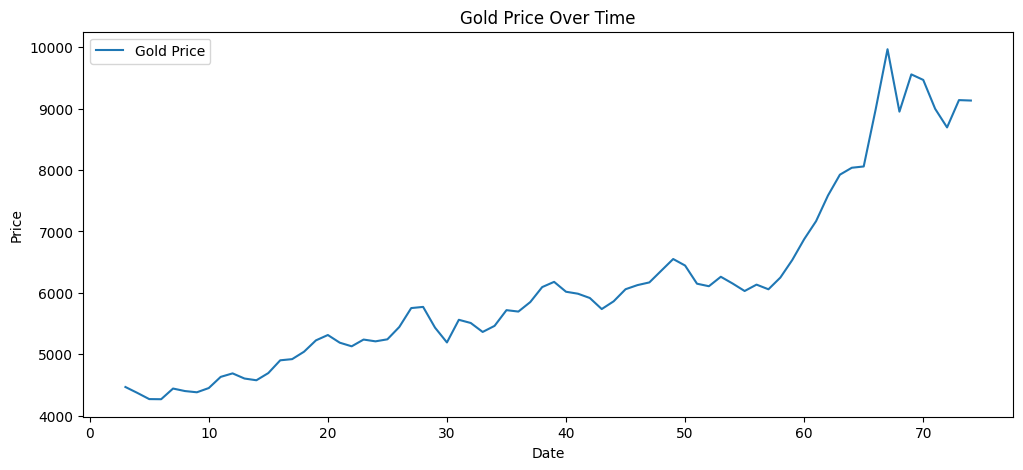

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(data['Gold_Price'], label='Gold Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

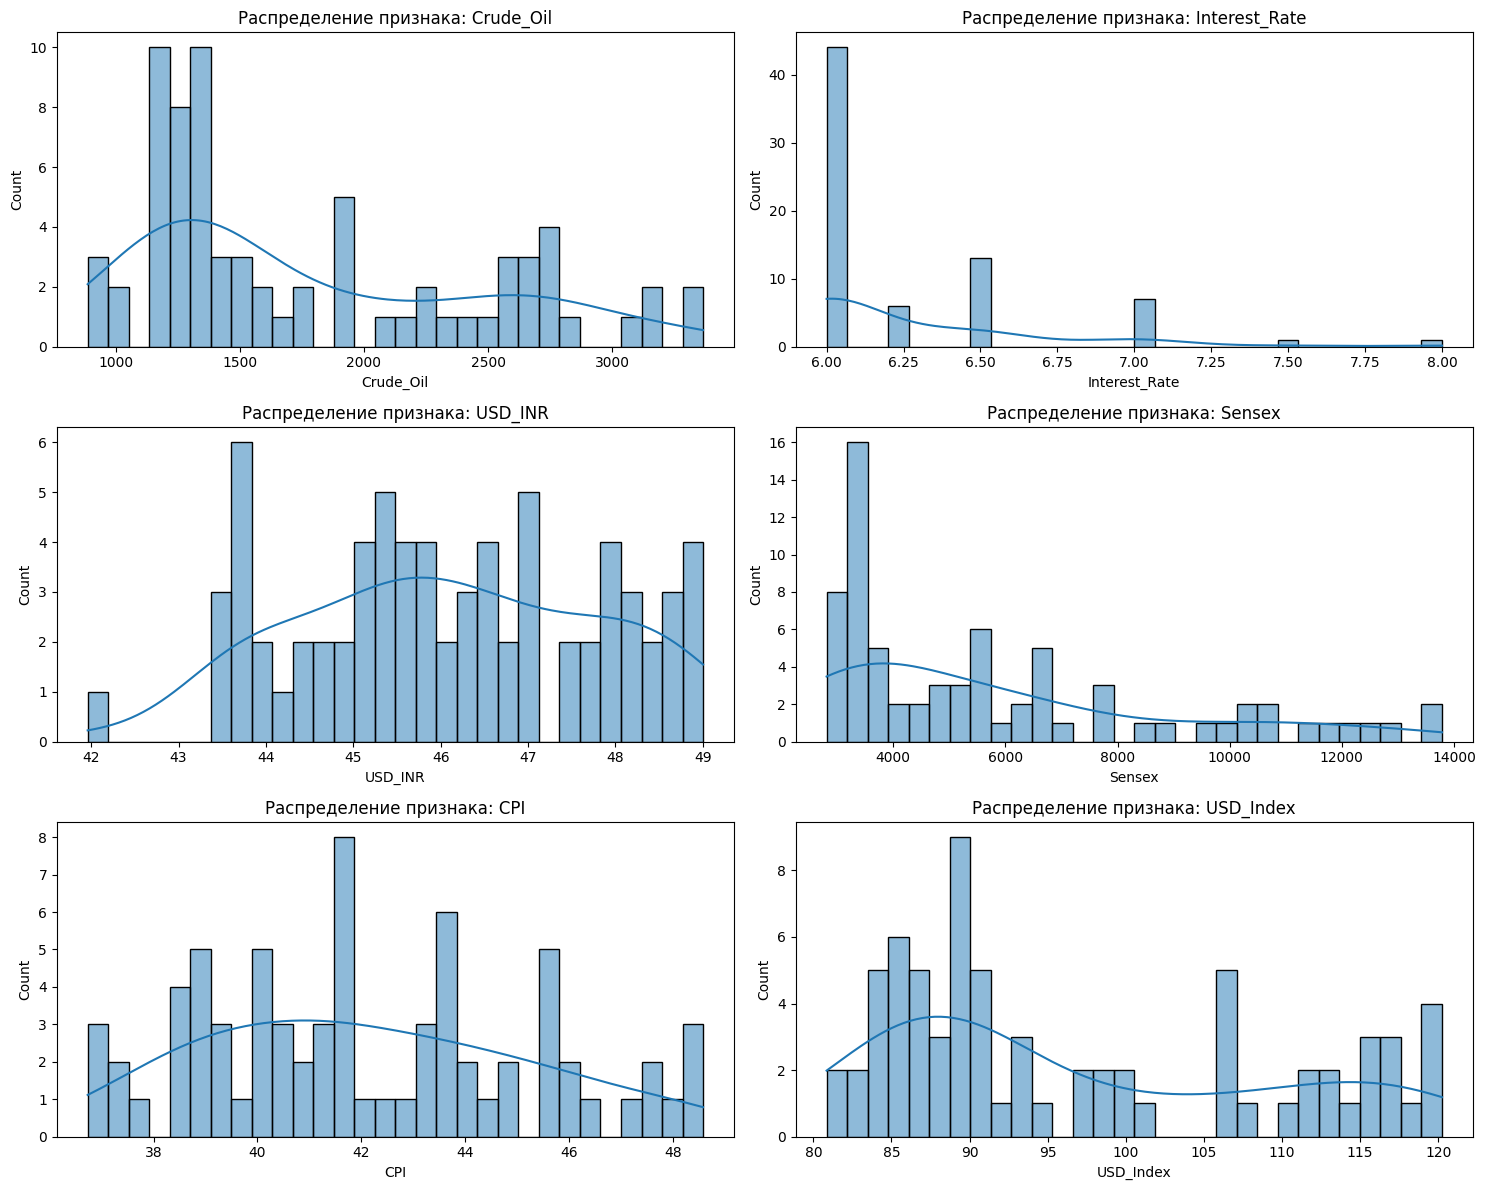

In [ ]:
features = ['Crude_Oil', 'Interest_Rate', 'USD_INR', 'Sensex', 'CPI', 'USD_Index']

plt.figure(figsize=(15, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=data, x=col, kde=True, bins=30)
    plt.title(f'Распределение признака: {col}')
plt.tight_layout()
plt.show()

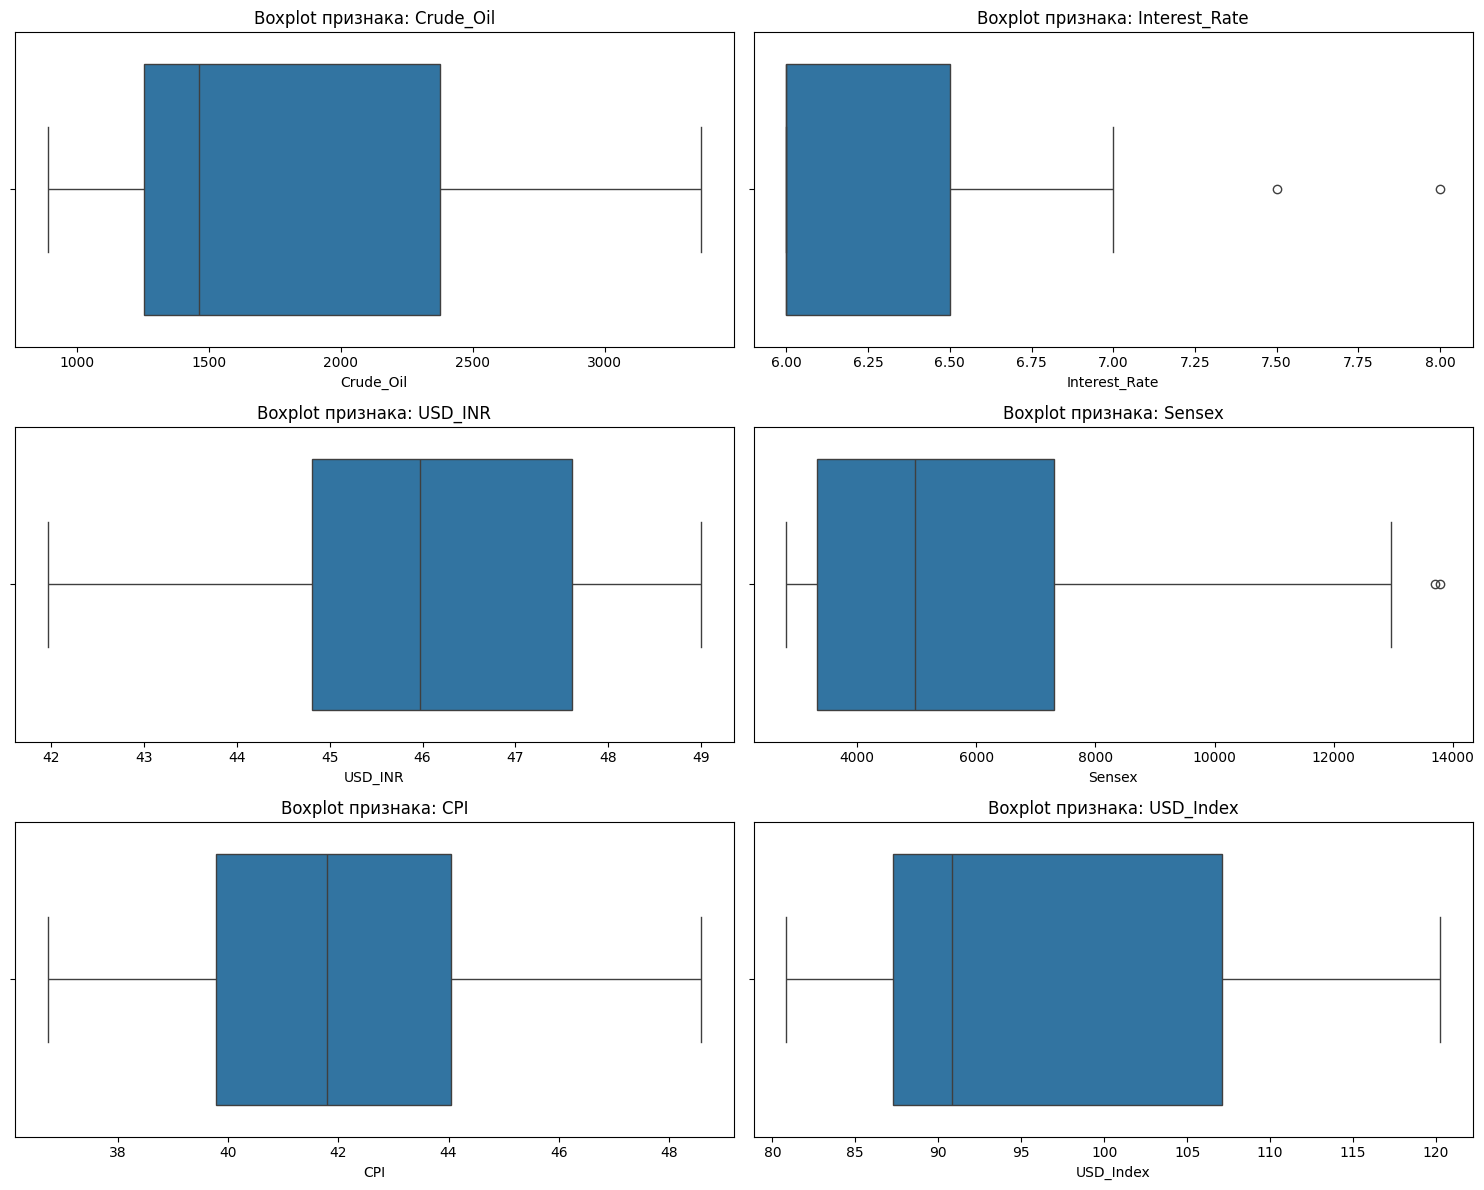

In [ ]:
features = ['Crude_Oil', 'Interest_Rate', 'USD_INR', 'Sensex', 'CPI', 'USD_Index']

plt.figure(figsize=(15, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot признака: {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

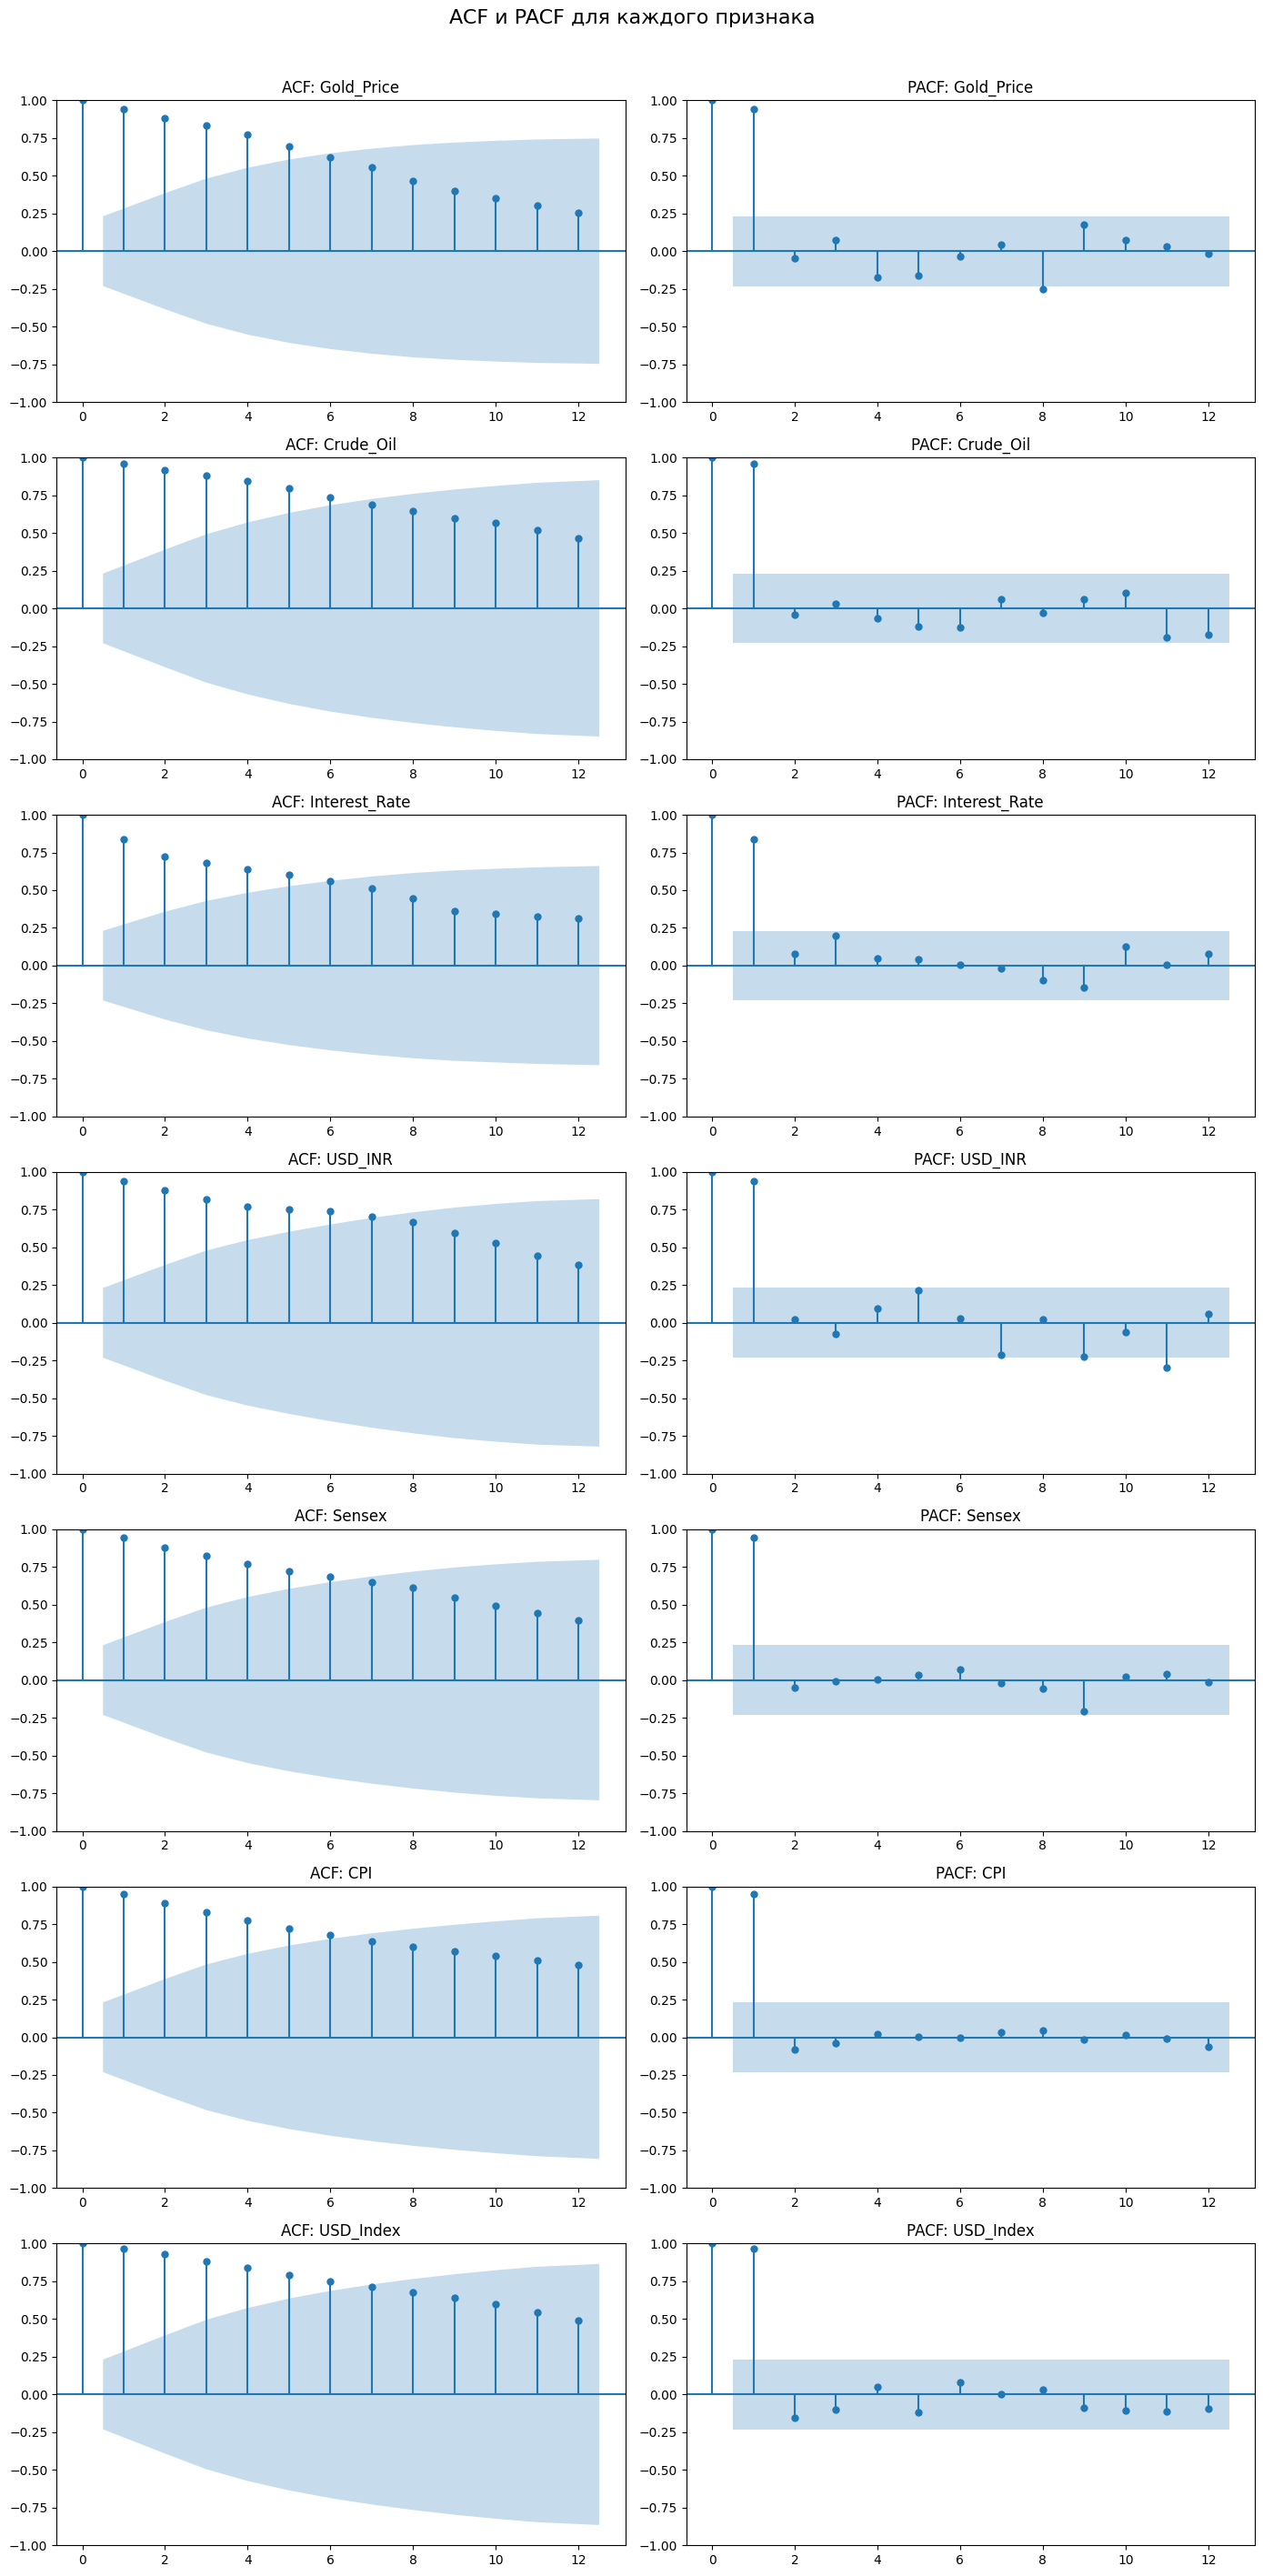

In [ ]:
data_sorted = data.sort_values('Date')
features = ['Gold_Price', 'Crude_Oil', 'Interest_Rate', 'USD_INR', 'Sensex', 'CPI', 'USD_Index']

fig, axes = plt.subplots(len(features), 2, figsize=(14, 4 * len(features)))
fig.suptitle('ACF и PACF для каждого признака', fontsize=16, y=1.01)

for i, col in enumerate(features):
    plot_acf(data_sorted[col], ax=axes[i, 0], lags=12, title=f'ACF: {col}')
    plot_pacf(data_sorted[col], ax=axes[i, 1], lags=12, title=f'PACF: {col}')

plt.tight_layout()
plt.show()

Вывод: все наши признаки имеют автокорреляцию, судя по значениям AFT. Кроме того, видим большие пики на первом и втором лагах, судя по PACF, можно будет в дальнейшем использовать это при выборе лаговых признаков

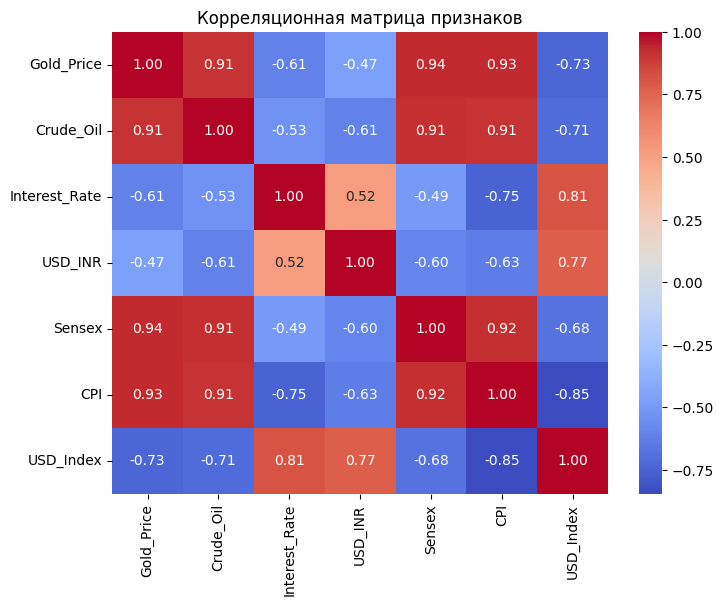

In [45]:
features = ['Gold_Price', 'Crude_Oil', 'Interest_Rate', 'USD_INR', 'Sensex', 'CPI', 'USD_Index']
plt.figure(figsize=(8, 6))
corr_matrix = data[features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()


Видим сильную корреляцию почти у всех признаков, попробуем отфильтровать их таким образом, чтобы не было корреляции между факторами, но чтобы сохранить как можно больше факторов, коррелирующих с целевой переменной

In [ ]:
features = ['Crude_Oil', 'Interest_Rate', 'USD_INR', 'Sensex', 'CPI', 'USD_Index']
X = data[features]

X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

         Feature           VIF
0          const  10497.711056
1      Crude_Oil      9.358912
2  Interest_Rate      5.912008
3        USD_INR      3.125174
4         Sensex     14.617375
5            CPI     38.661910
6      USD_Index      8.218105


Возьмем признак Sensex, так как у него сама сильная корреляция с целевой переменной и в качестве второго фактора возьмем Interest_Rate, потому что у него самая слабая корреляция с Sensex

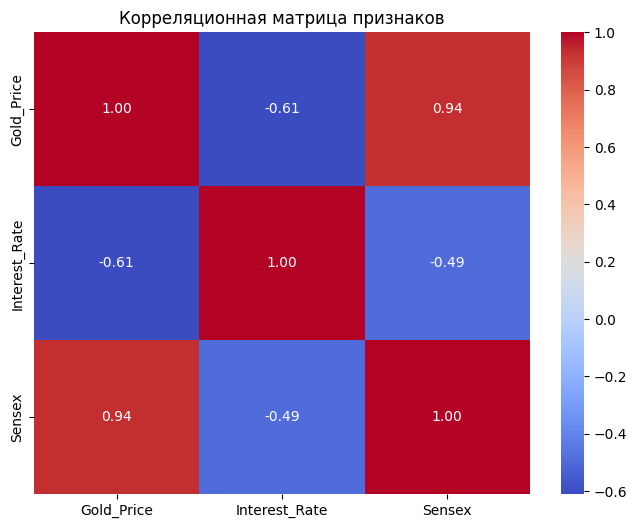

In [47]:

features = ['Gold_Price', 'Interest_Rate', 'Sensex']
plt.figure(figsize=(8, 6))
corr_matrix = data[features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()

Берем данные с 1 января 2001 года по 1 декабря 2005 года как обучающую выборку, а с 1 января по 1 декабря 2006 года как тестовую

In [ ]:
train_mask = (data['Date'] >= '2001-01-01') & (data['Date'] <= '2005-12-01')
train_data = data.loc[train_mask]

test_mask = (data['Date'] >= '2006-01-01') & (data['Date'] <= '2006-12-01')
test_data = data.loc[test_mask]

features = ['Interest_Rate', 'Sensex']
X_train = train_data[features]
y_train = train_data['Gold_Price']

X_test = test_data[features]
y_test = test_data['Gold_Price']

In [ ]:
X_train_const = add_constant(X_train, has_constant='add')
X_test_const = add_constant(X_test, has_constant='add')

model = OLS(y_train, X_train_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Gold_Price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     212.7
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           3.67e-27
Time:                        13:00:08   Log-Likelihood:                -418.99
No. Observations:                  60   AIC:                             844.0
Df Residuals:                      57   BIC:                             850.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.003e+04    659.634     15.198

Выводы:
- Модель объясняет 88.2% вариации целевой переменной (Gold_Price)
- F-statistic = 212.7 (p < 0.0001)	Модель в целом статистически значима
Анализ коэффициентов:
- const = 10030 (p=0.000) - свободный член статистически значим
- Interest_Rate = -895.51 (p=0.000)	При увеличении Interest_Rate на 1 ед., Gold_Price уменьшается в среднем на 895.51, очень значимо
- Sensex = 0.2482 (p=0.000)	При увеличении Sensex на 1 ед., Gold_Price растёт на 0.2482, тоже значимо.

Кроме того:
-  Durbin-Watson: 0.528, что указывает на положительную автокорреляцию. 

Насчет проблемы автокорреляции - у нас данные в формате временного ряда, поэтому автокорреляция неизбежна

In [ ]:
X = data[['Interest_Rate', 'Sensex']]
X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_data)

coef = model.params[['Interest_Rate', 'Sensex']]

std_y = np.std(data['Gold_Price'])
std_x = data[['Interest_Rate', 'Sensex']].std()

elasticity = coef * std_x / std_y
print("Коэффициенты эластичности:\n", elasticity)

         feature         VIF
0          const  352.176181
1  Interest_Rate    1.324043
2         Sensex    1.324043
Коэффициенты эластичности:
 Interest_Rate   -0.254884
Sensex           0.528305
dtype: float64


Sensex оказывает более сильное влияние на целевую переменную, поэтому попробуем исключить Interest_Rate и посмотрим, что получится

In [ ]:
features1 = ['Sensex']
X_train1 = train_data[features1]
y_train1 = train_data['Gold_Price']

X_test1 = test_data[features1]
y_test1 = test_data['Gold_Price']

X_train_const1 = add_constant(X_train1, has_constant='add')
X_test_const1 = add_constant(X_test1, has_constant='add')

model1 = OLS(y_train1, X_train_const1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:             Gold_Price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     131.6
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.50e-16
Time:                        13:00:08   Log-Likelihood:                -447.54
No. Observations:                  60   AIC:                             899.1
Df Residuals:                      58   BIC:                             903.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3820.4834    160.808     23.758      0.0

In [ ]:
# Interest_Rate + Sensex
R2_full = 0.882
# только Sensex
R2_reduced = 0.694    

n = 60       # общее число наблюдений
m = 2        # число факторов в полной модели
m1 = 1       # число факторов в упрощённой модели
m2 = m - m1  # число исключённых факторов

# Формула Фишера
F1 = ((R2_full - R2_reduced) / m2) * ((n - m - 1) / (1 - R2_full))
print("F1:", F1)
f_critical = f.ppf(1 - 0.05, dfn=1, dfd=57)
print("F-критическое:", f_critical)

F1: 90.81355932203392
F-критическое: 4.009867915653544


Поскольку 90.84 > 4.01, мы отвергаем нулевую гипотезу.
Исключённый фактор (Interest_Rate) значимо улучшает модель и должен быть включён

### Оценка модели и остатков

In [ ]:
y_pred = model.predict(X_test_const)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
smape = 100 * np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred)))
mpe = np.mean((y_test - y_pred) / y_test) * 100

residuals = model.resid
residuals_sum = residuals.sum()
residuals_mean = residuals.mean()
durbin_watson = sum(np.diff(residuals) ** 2) / sum(residuals ** 2)

results = {
    "R_squared": model.rsquared,
    "F_statistic": model.fvalue,
    "F_pvalue": model.f_pvalue,
    "is_model_significant": model.f_pvalue < 0.05,
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "sMAPE": smape,
    "MPE": mpe,
    "Sum of residuals": residuals_sum,
    "Mean of residuals": residuals_mean,
    "Durbin-Watson": durbin_watson
}

df_pretty = pd.DataFrame.from_dict(results, orient='index', columns=['Значение'])
print(df_pretty.to_string(float_format='{:,.4f}'.format))

### Сделаем новые переменные с лагами

In [ ]:
def create_lagged_features(df, features, lags):

    df_lagged = df.copy()
    for feature, lag in zip(features, lags):
        if lag > 0:
            df_lagged[f"{feature}_lag{lag}"] = df_lagged[feature].shift(lag)
        else:
            df_lagged[f"{feature}_lag0"] = df_lagged[feature]
    return df_lagged

def tune_lmfm_all_lags(data, target_col, feature_cols, max_lag=3, min_window_size=None):
    n = len(data)
    if min_window_size is None:
        min_window_size = 8 * len(feature_cols)
    
    best_rmse = np.inf
    best_params = None
    best_model = None

    lag_combinations = list(product(range(max_lag + 1), repeat=len(feature_cols)))
    
    for lags in lag_combinations:
        data_lagged = create_lagged_features(data, feature_cols, lags)
        
        for sb in range(0, n - min_window_size):
            for se in range(sb + min_window_size, n + 1):
                subset = data_lagged.iloc[sb:se].dropna()
                if len(subset) < min_window_size:
                    continue
                
                lagged_feature_names = [f"{f}_lag{lag}" for f, lag in zip(feature_cols, lags)]
                
                X = subset[lagged_feature_names]
                y = subset[target_col]
                
                if X.empty or y.empty:
                    continue
                
                X_const = add_constant(X)
                
                try:
                    model = OLS(y, X_const).fit()
                    y_pred = model.predict(X_const)
                    rmse = np.sqrt(np.mean((y - y_pred)**2))
                    
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {
                            'lags': lags,
                            'start_index': sb,
                            'end_index': se
                        }
                        best_model = model
                
                except Exception as e:
                    continue
    
    return best_model, best_params, best_rmse

target_col = 'Gold_Price'
feature_cols = ['Interest_Rate', 'Sensex']

best_model, best_params, best_rmse = tune_lmfm_all_lags(data, target_col, feature_cols, max_lag=3)

print("Лучшие параметры:", best_params)
print("Лучший RMSE:", best_rmse)
print(best_model.summary())


Лучшие параметры: {'lags': (2, 0), 'start_index': 26, 'end_index': 42}
Лучший RMSE: 87.4986894833804
                            OLS Regression Results                            
Dep. Variable:             Gold_Price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     57.77
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           3.40e-07
Time:                        13:04:07   Log-Likelihood:                -94.249
No. Observations:                  16   AIC:                             194.5
Df Residuals:                      13   BIC:                             196.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------

C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)
